In [4]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats, integrate

import cvxpy as cp

In [5]:
def import_data(tickers, start, end, give = "R", adj_close = True, dividend = True):#read in stock data  
    """
    tickers: tickers to read 
    start, end: dates in datetime.datetime(2015,12,1) format
    give: return prices or returns 
    adj_close: use adjusted or unadjusted price
    dividend: include dividend?
    """
    
    if give=='D':
        adj_close=False
        dividend = True
    
    stocks = pd.DataFrame()
    if (adj_close == True):
        dividend = False
        stocks[tickers] = data.DataReader(tickers, 'yahoo', start, end)['Adj Close']
    else:
        stocks[tickers] = data.DataReader(tickers, 'yahoo', start, end)['Close']
            
        if (dividend == True): 
            stock_div = pd.DataFrame(index=stocks.index)
            for tick in tickers:
                stock_div[tick+' div'] = data.DataReader(tick, 'yahoo-dividends', start, end)["value"]
      
    just_stocks=stocks
    if (dividend == True):
        stocks = pd.concat([stocks,stock_div],axis=1)
        stocks = stocks.fillna(0)
        
    if(give == "R"):
        #Adding dividends to price appreciation on a daily percent return basis -useful for all analysis
        raw_returns=pd.DataFrame()
        for tick in tickers:
            if (dividend == True):
                raw_returns[tick] = stocks[tick].pct_change() + stocks[tick+' div']/stocks[tick] 
                #dividends are actually added on the day before they should be added but this error is neglegible
            else:
                raw_returns[tick] = stocks[tick].pct_change()
        returns=raw_returns[1:]
        return returns[np.isfinite(returns).all(1)]
        
    if(give == "P"):
        return just_stocks
    
    if(give=="D"):
        dividend = pd.DataFrame(np.array(stocks.iloc[:,len(just_stocks.columns):])/np.array(stocks.iloc[:,:len(just_stocks.columns)])).set_index(just_stocks.index)
        dividend.columns=just_stocks.columns
        return dividend

In [53]:
start = datetime(1995,1,1)
end = datetime(2015,6,19)#when XLRE,XLC was introduced
tickers = ['XLV','XLI','XLB','XLK','XLU','XLY','XLP','XLF','XLE'] #XLRE, XLC
sectordata = import_data(tickers, start, end).resample("M").apply(lambda x: ((x + 1).cumprod()-1).last("D")) 

In [55]:
sectordata.shape

(199, 9)

<AxesSubplot:xlabel='Date'>

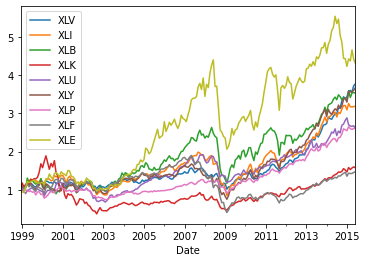

In [66]:
(sectordata+1).cumprod().plot()

In [56]:
def calculate_posterior_mean(like_pop, prior_pop):
    mu0 = prior_pop.mean()
    w0 = prior_pop.std()
    dbar = like_pop.mean()
    w = like_pop.std()
    # Prior:
    prior = stats.norm(mu0, w0)
    # Likelihood:
    like = stats.norm(dbar, w)
    #computer posterior mean, std, distribution
    B = w**2/(w**2+w0**2)
    mu_s =dbar+B*(mu0-dbar)
    w_s = w*np.sqrt(1-B)
    posterior = stats.norm(mu_s, w_s)
    return mu_s

#calculated expected return array
def likelihood_n_posterior_mus(n, data, period=16): #period of 16 is 3 months with weekly data
    like_mus = np.zeros(len(data.columns))
    post_mus = np.zeros(len(data.columns))
    for ints,sector in enumerate(data
                                 .columns): 
        likelihood_pop = np.array(data.iloc[n-period : n - 1][sector])
        prior_pop = np.array(data.iloc[n-period : n - 1])
        like_mus[ints] = likelihood_pop.mean() #normal mean opt 
        post_mus[ints] = calculate_posterior_mean(likelihood_pop,prior_pop) #bayesian means 
    return like_mus, post_mus

In [69]:
def max_sharpe(mu,cov):
    # Minimize portfolio Sharpe for given return (ret)
    z = cp.Variable(len(mu),) #transformed variable
    k = cp.Variable() #scalar (variable)
    ret = z.T @ mu
    sigma_square = cp.quad_form(z, cov)
    objective = cp.Minimize (sigma_square)
    constraints = [
                    ret == 1, #adjustable return target constraint
                    cp.sum(z) == k,
                    z >= 0,
                    k >= 0
                    ]
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose = False)
    return (z.value / k.value)

def weighted_stuff(n, dat):
    dat = np.array(dat)
    alpha = 0.5
    weights = np.flip((1-alpha)**np.arange(0,len(dat),1))
    weights = weights/np.sum(weights) # normalize
    weighted = dat.T*weights
    w_means = np.sum(weighted,axis=1)                             # weighted means
    w_covs = dat.T@np.diag(weights)@dat-np.outer(w_means,w_means) # weighted covs
    return w_covs #w_means, 

def tangent_rebalance(stocks, n, formation_period, port, weights, total, expt_rtn = 'like', Lower_bound=0, Upper_bound=1,annualizer = 52, muf = 0, wcov = False):
    likeMu, postMu = likelihood_n_posterior_mus(n, period=formation_period, data = stocks)
    if wcov == False:
        cov = stocks[n-formation_period : n - 1].cov()
    if wcov == True:
        cov = weighted_stuff(n, stocks[n-formation_period : n - 1]) #weighted cov
    if expt_rtn == 'like':
        tangent_weights = max_sharpe(likeMu,cov)
    elif expt_rtn == 'not like':
        tangent_weights = max_sharpe(postMu,cov)
    return tangent_weights

In [70]:
def backtest(weights, col, dataf, expt_rtns = 'like', wcov = False, days_between_rebalance=1, show_weights=False, wealth = 1, RebalanceOffset=0, give='R',formation = 0): #cols allows users to backtest subsets of dataframe
    """
    weights: tells the function the number of assets. sets the starting weights and is the weights for constant rebalancing
    wealth: sets starting value
    RebalanceOffset: to offset day of rebalances by these values to provide information about rebalance timing luck
    give: return returns or prices
    formation: number of days covariance matrix is formed over
    
    """
    colin=[0]*len(weights)
    port=[0]*len(weights)
    worth=[wealth]

    for n in range(len(weights)):
        colin[n] = dataf.columns.get_loc(col[n])
        port[n]=wealth*weights[n]

    for n in range (formation,len(dataf)):
        port = np.multiply(port, np.array((1+dataf.iloc[n,colin])))
        end_of_day = sum(port)
        worth.append(end_of_day)
        
        if ((n + RebalanceOffset)% days_between_rebalance==0):        #rebalance
            port=tangent_rebalance(dataf, n, formation, port, weights, total = sum(port), expt_rtn = expt_rtns, wcov = wcov)
            if show_weights == True:
                print(np.round(np.array(port/sum(port)),2))
                
    if (give=='R'):            
        p_rtn = pd.DataFrame(worth).pct_change()[1:].set_index(dataf.index[formation:])
        return(p_rtn)
    if (give=='P'):
        return(pd.DataFrame(worth[1:]).set_index(dataf.index[formation:]))

In [60]:
initial_weights = np.ones(len(sectordata.columns))/len(sectordata.columns)

#standard covariance 5 yr lookback for expted returns and covariance
likelihood = backtest(initial_weights, sectordata.columns, sectordata, formation = 5*12, expt_rtns = 'like')
posterior = backtest(initial_weights, sectordata.columns, sectordata, formation = 5*12, expt_rtns = 'not like')

In [61]:
comparisons = pd.concat([likelihood.rename({0:'like'},axis=1),posterior.rename({0:'post'},axis=1)], axis=1)

<AxesSubplot:xlabel='Date'>

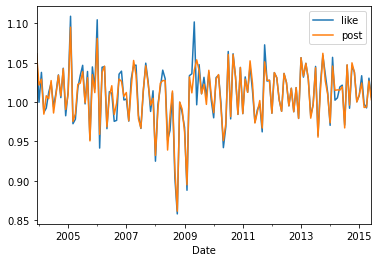

In [62]:
((comparisons+1).cumprod()).plot()

In [63]:
comparisons.corr()

,like,post
like,1.000000,0.958273
post,0.958273,1.000000


In [71]:
initial_weights = np.ones(len(sectordata.columns))/len(sectordata.columns)

#standard covariance 5 yr lookback for expted returns and covariance
likelihood = backtest(initial_weights, sectordata.columns, sectordata, formation = 5*12, expt_rtns = 'like', wcov = True)
posterior = backtest(initial_weights, sectordata.columns, sectordata, formation = 5*12, expt_rtns = 'not like',  wcov = True)

In [72]:
wcov_comparisons = pd.concat([likelihood.rename({0:'like'},axis=1),posterior.rename({0:'post'},axis=1)], axis=1)

<AxesSubplot:xlabel='Date'>

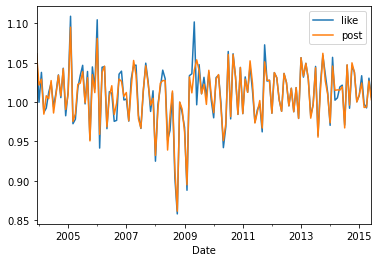

In [73]:
((comparisons+1).cumprod()).plot()